In [1]:
from __future__ import print_function
import morphs

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import itertools

from morphs.data.derivative import f_poly, f_map

/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dd = morphs.load.derivative_dict()
ddf = morphs.load.derivative_df()

In [3]:
def _derivative_plot(orders=range(7), normalize=True, **kwargs):
    x = np.linspace(1, 128)
    data = kwargs.pop("data")
    morph_dim = data["morph_dim"].values[0]
    #     cmap = sns.cubehelix_palette(7, start=2.5, rot=1, dark=0.1, light=0.5)
    #     cmap = sns.color_palette("GnBu_d", 7)[::-1]
    cmap = sns.color_palette("husl", 7)
    ax = plt.gca()
    y_hat = {}
    for order in orders:
        ys = data[order][data[order].str[0].notna()].map(f_map)
        for y in ys:
            ax.plot(x, y, alpha=0.2 / len(orders), color=cmap[order])
        y_hat[order] = ys.mean()
    for order in orders:
        ax.plot(x, y_hat[order], color=cmap[order])
    morphs.plot.boundary(ax, morph_dim)

def derivative_plot(ddf, **kwargs):
    g = morphs.plot.morph_grid(
        ddf,
        _derivative_plot,
        "Thielkness",
        **kwargs
    )
    g = g.set(ylim=(0, 0.05), xlim=(1, 128), yticks=[])
    return g

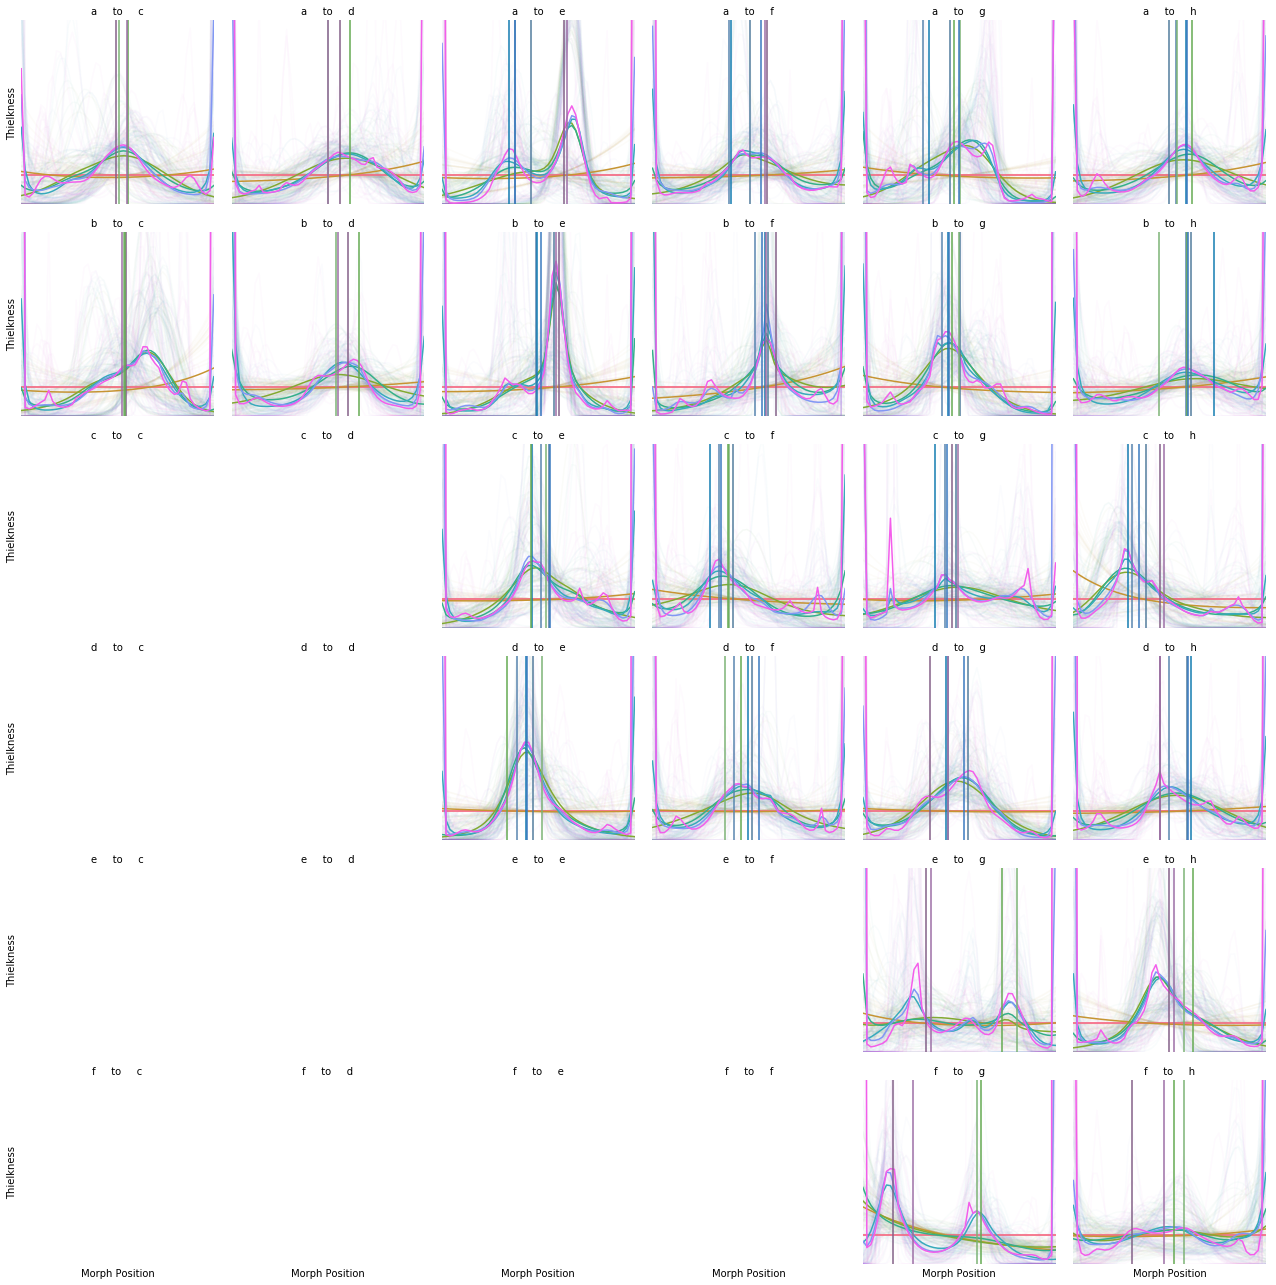

In [4]:
g = derivative_plot(ddf)

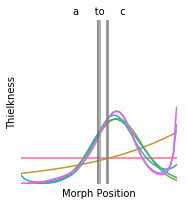

In [5]:
for selected_block_path in ddf["block_path"].unique():
    if "Pen01_Lft_AP2500_ML500__Site06_Z3000__B1183_cat_P01_S06_5" in selected_block_path:
        break
g = derivative_plot(ddf[ddf["block_path"] == selected_block_path], row_order=["a"], col_order=["c"])

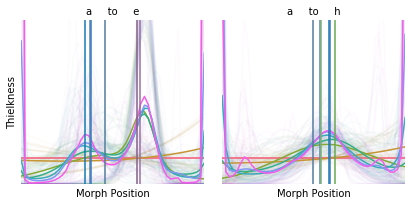

In [6]:
g = derivative_plot(ddf, row_order=["a"], col_order=["e", "h"])

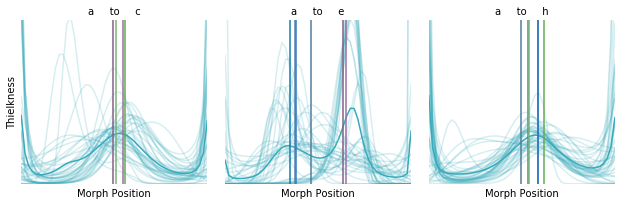

In [7]:
g = derivative_plot(ddf, row_order=["a"], col_order=["c", "e", "h"], map_kwargs={"orders": [4]})

In [8]:
def gen_boundary_df(block_path, morph_dim, order):
    psychometric_params = morphs.load.psychometric_params()
    popt = dd[block_path][morph_dim][order]
    boundary_df = pd.DataFrame(
        [
            (
                boundary_subj,
                boundary_dim,
                psychometric_params[boundary_subj][boundary_dim][3],
            )
            for boundary_subj in psychometric_params
            for boundary_dim in psychometric_params[boundary_subj]
        ],
        columns=["boundary_subj", "boundary_dim", "boundary_loc"],
    )
    boundary_df["fval"] = (
        f_poly(boundary_df["boundary_loc"].values, popt)
        / sp.integrate.quad(f_poly, 1, 128, args=(popt,))[0]
    )
    boundary_df["morph_dim"] = morph_dim
    boundary_df["block_path"] = block_path
    boundary_df["order"] = order
    return boundary_df

In [9]:
deriv_val_df = pd.concat([gen_boundary_df(block_path, morph_dim, order)
            for order in range(7)
            for block_path in dd
            for morph_dim in dd[block_path]], ignore_index=True)

deriv_val_df["matched"] = deriv_val_df["boundary_dim"] == deriv_val_df["morph_dim"]

/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/usr/local/anaconda/envs/morphs36/lib/python3.6/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  

In [10]:
def ks_mapper(group, return_p=True):
    matched_groups = group.groupby("matched")
    d, p = sp.stats.mstats.ks_twosamp(
        matched_groups.get_group(False)["fval"].values,
        matched_groups.get_group(True)["fval"].values,
        alternative="greater",
    )
    return p if return_p else d

In [11]:
deriv_val_df.groupby("order").apply(ks_mapper)

order
0     9.139957e-01
1     7.133268e-30
2     9.233846e-57
3    3.786218e-105
4    1.472594e-121
5    2.096174e-136
6    1.472099e-138
dtype: float64

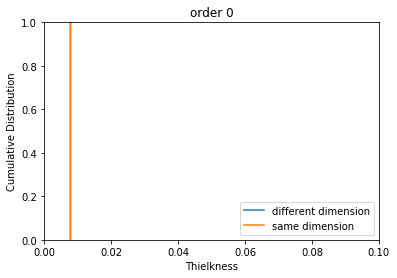

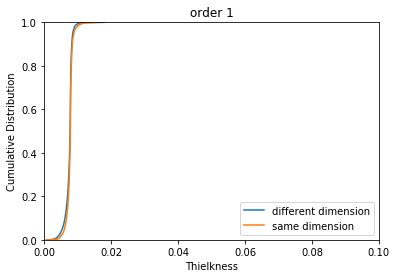

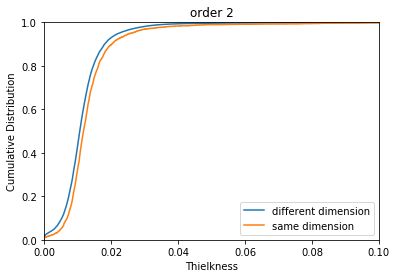

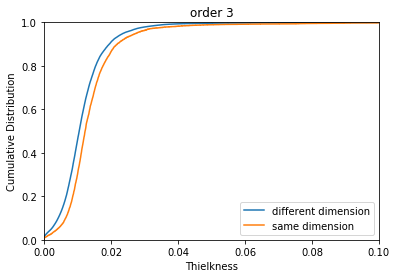

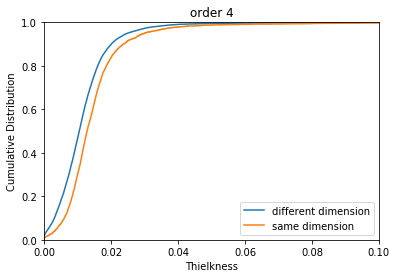

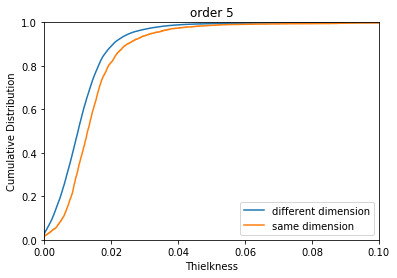

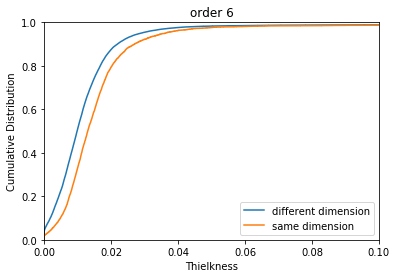

In [12]:
for order, order_group in deriv_val_df.groupby("order"):
    matched_groups = order_group.groupby("matched")
    fig = plt.figure()
    ax = plt.gca()
    for matched, matched_group in matched_groups:
        morphs.plot.cumulative_distribution(
            matched_group["fval"].values,
            scaled=True,
            label="same dimension" if matched else "different dimension",
        )
    ax.set_ylim(0, 1)
    ax.set_xlim(0, .1)
    ax.set_ylabel("Cumulative Distribution")
    ax.set_xlabel("Thielkness")
    ax.legend(loc="lower right");
    ax.set_title("order %d" % (order))

In [13]:
deriv_val_df["neural_subj"] = deriv_val_df["block_path"].map(morphs.data.parse.bird_id)
morphs.data.parse.ephys_class(deriv_val_df, behavior_subj_label="boundary_subj", neural_subj_label="neural_subj")

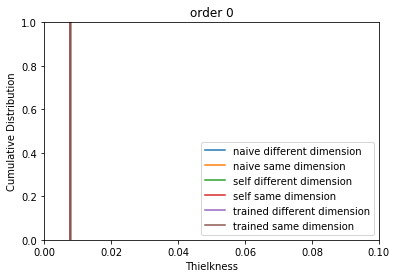

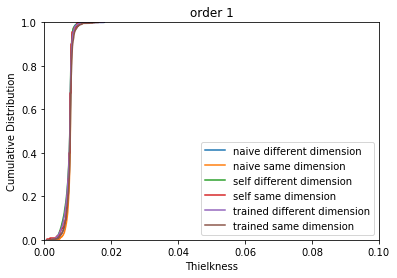

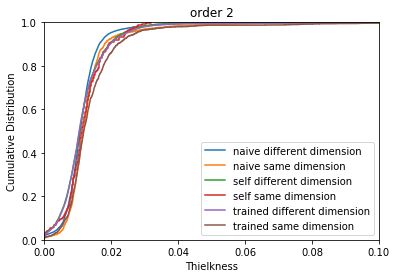

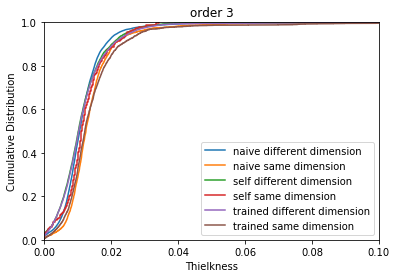

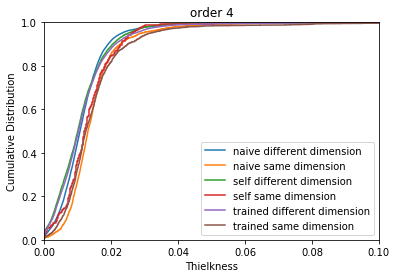

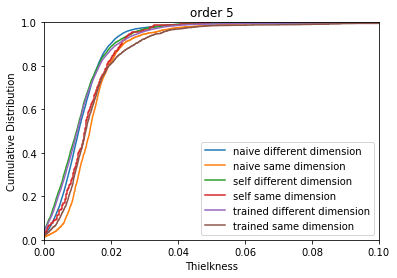

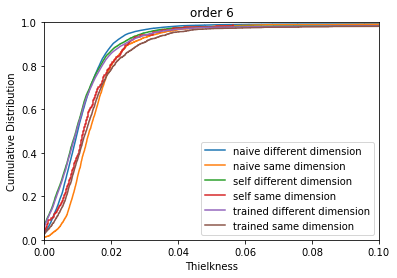

In [14]:
for order, order_group in deriv_val_df.groupby("order"):
    fig = plt.figure()
    ax = plt.gca()
    for _class, class_group in order_group.groupby("class"):
        for matched, matched_group in class_group.groupby("matched"):
            morphs.plot.cumulative_distribution(
                matched_group["fval"].values,
                scaled=True,
                label=_class + (" same dimension" if matched else " different dimension"),
            )
    ax.set_ylim(0, 1)
    ax.set_xlim(0, .1)
    ax.set_ylabel("Cumulative Distribution")
    ax.set_xlabel("Thielkness")
    ax.legend(loc="lower right");
    ax.set_title("order %d" % (order))

In [15]:
block_subj_df = deriv_val_df.groupby(["order", "boundary_subj", "block_path"]).apply(ks_mapper, return_p=False).rename("d").reset_index()

In [16]:
block_subj_df["neural_subj"] = block_subj_df["block_path"].map(morphs.data.parse.bird_id)
morphs.data.parse.ephys_class(block_subj_df, behavior_subj_label="boundary_subj", neural_subj_label="neural_subj")

In [17]:
block_subj_df.groupby(["order", "class"])["d"].mean()

order  class  
0      naive      0.037228
       self       0.052632
       trained    0.037267
1      naive      0.191933
       self       0.178776
       trained    0.225400
2      naive      0.207558
       self       0.180206
       trained    0.234227
3      naive      0.272605
       self       0.217105
       trained    0.257927
4      naive      0.285326
       self       0.251144
       trained    0.260093
5      naive      0.311515
       self       0.253146
       trained    0.264077
6      naive      0.316780
       self       0.228261
       trained    0.256089
Name: d, dtype: float64

In [18]:
print("order", "vs", "class0", "class1", "d", "p")
for order, order_group in deriv_val_df.groupby("order"):
    for matched, matched_group in order_group.groupby("matched"):
        if matched:
            class_gb = order_group.groupby("class")
            for class0, class1 in itertools.combinations(class_gb.groups.keys(), 2):
                d, p = sp.stats.mstats.ks_twosamp(
                    class_gb.get_group(class0)["fval"].values,
                    class_gb.get_group(class1)["fval"].values,
                    alternative="two-sided",
                )
                print(order, "vs", class0, class1, d, p)

order vs class0 class1 d p
0 vs naive self 0.019407894736848626 0.014702155181923516
0 vs naive trained 0.019407894736864627 1.501711145378141e-09
0 vs self trained 3.942228488096333e-13 1.0
1 vs naive self 0.10726682428731187 1.3293680715553559e-65
1 vs naive trained 0.0927771087876847 6.151176232910745e-209
1 vs self trained 0.042704417293251876 1.544058873444034e-10
2 vs naive self 0.07232044956136294 4.7204813073846026e-30
2 vs naive trained 0.07907378309045723 6.842818047017057e-152
2 vs self trained 0.010494987468664578 0.48287819676517385
3 vs naive self 0.07345206277413013 5.489988451659702e-31
3 vs naive trained 0.06436623786028299 8.706501583628449e-101
3 vs self trained 0.013764880952399514 0.17786405866857719
4 vs naive self 0.08491810581141174 2.8406467573780085e-41
4 vs naive trained 0.06433833607456986 1.0637386078517582e-100
4 vs self trained 0.02349624060150981 0.0017367755787672983
5 vs naive self 0.0800738418311532 9.569697512857297e-37
5 vs naive trained 0.059849697

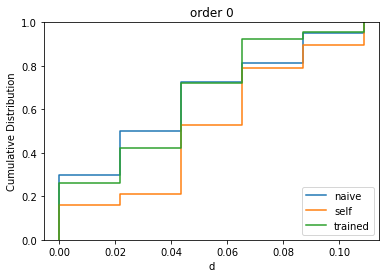

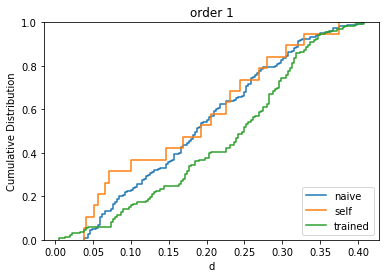

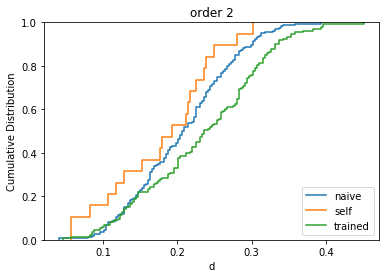

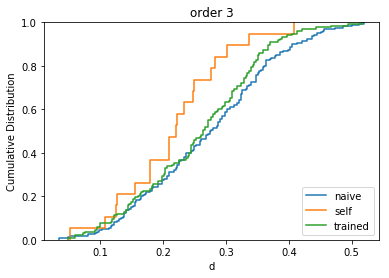

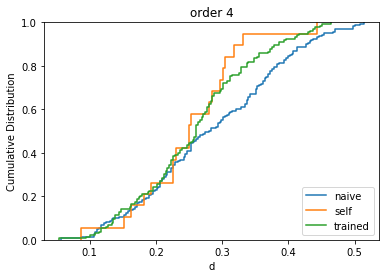

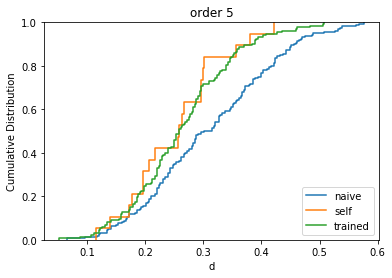

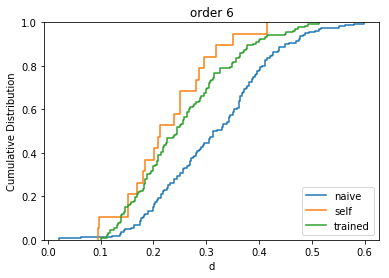

In [19]:
for order, order_group in block_subj_df.groupby("order"):
    fig = plt.figure()
    ax = plt.gca()
    for _class, class_group in order_group.groupby("class"):
        morphs.plot.cumulative_distribution(
            class_group["d"].values,
            scaled=True,
            label=_class,
        )
    ax.set_ylim(0, 1)
    ax.set_ylabel("Cumulative Distribution")
    ax.set_xlabel("d")
    ax.legend(loc="lower right");
    ax.set_title("order %d" % (order))

There may be something worth arguing about how naive birds might have better peaks, but there are considerable caveats to this kind of interpretation so I won't bother for now.